In [5]:
import numpy as np
import pylab as plt
import obspy
from obspy.signal.util import util_geo_km
from itertools import product
from tqdm import tqdm
import matplotlib.patheffects as pe

plt.style.use("colorblind")


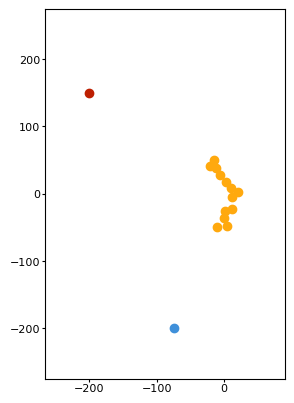

In [6]:
master_station = np.array([-75, -200])
inv = obspy.read_inventory("../meta/graefenberg.stationxml")
array_stations_latlon = np.array([(sta.longitude, sta.latitude) for sta in inv[0]])

isolated_source = np.array([-200, 150])

array_stations = []
for sta in array_stations_latlon:
    array_stations.append(
        util_geo_km(
            np.mean(array_stations_latlon[:, 0]),
            np.mean(array_stations_latlon[:, 1]),
            sta[0],
            sta[1],
        )
    )
array_stations = np.array(array_stations)

grid_points = np.array(list(product(np.arange(-250, 250, 1), repeat=2)))
grid_points = np.array([gp for gp in grid_points if gp[0] < 75])

fig, ax = plt.subplots(1, 1)
ax.set_aspect("equal")
ax.scatter(*master_station)
ax.scatter(*array_stations.T)
ax.scatter(*isolated_source)

ax.scatter(*grid_points.T, s=1, alpha=0.1, c="w", zorder=0)

# ax.pcolorfast(grid_points.reshape(np.arange(-250, 250, 0.5).shape, np.arange(-250, 250, 0.5).shape), alpha=.1)


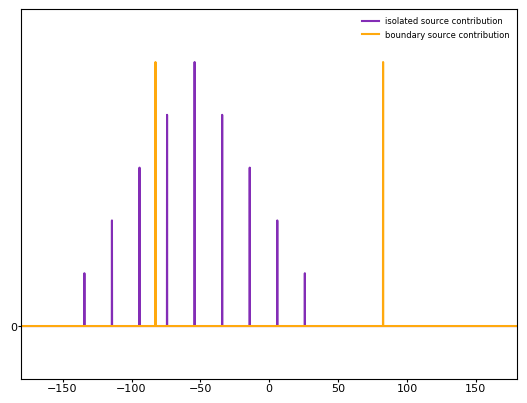

In [7]:
import numpy as np
from scipy.signal import ricker, fftconvolve

# from obspy import read_inventory
from obspy.geodetics import gps2dist_azimuth

# Define time
freq = 10
timelen = 1200
times = np.arange(0, timelen + 1 / freq, 1 / freq)
lapsetimes = times - times[-1] / 2

# Define geometry
# for computation of Green's functions and their correlation
# inv = read_inventory("meta/graefenberg.stationxml")
# station = np.array([inv[0][0].longitude, inv[0][0].latitude])
# master_station = np.array([2.26, 48.0258])
# isolated_source = np.array([-23, 62.5])
dist_master = np.linalg.norm(master_station - isolated_source)
dist_station = np.linalg.norm(array_stations[0] - isolated_source)

# Define medium
# acoustic, isotropic, homogeneous half-space
vel = 3

# Define isolated source wavelet & excitation pattern
wavelet = ricker(len(times), 2 * freq)

n_repeat = 5
interval = 20
excitation_pattern = np.zeros(len(times))
excitation_pattern[
    int(interval * freq) : (n_repeat + 1) * int(interval * freq) : int(interval * freq)
] = 1

# Green's functions = Dirac delta functions
gf_master = np.zeros(len(times))
gf_master[int(freq * dist_master / vel)] = 1
gf_station = np.zeros(len(times))
gf_station[int(freq * dist_station / vel)] = 1

# Correlations
wavelet_autocorr = fftconvolve(wavelet, wavelet[::-1], mode="same")
excitation_pattern_autocorr = fftconvolve(
    excitation_pattern, excitation_pattern[::-1], mode="same"
)
gf_corr = fftconvolve(gf_station, gf_master[::-1], mode="same")

# Isolated noise source contribution to the correlation wavefield
# second term of eq. 2, Schippkus et al. 2023
isolated_source_contribution = fftconvolve(
    excitation_pattern_autocorr, gf_corr, mode="same"
)

# boundary_contribution

gf = np.zeros(len(lapsetimes))
tt = np.linalg.norm(master_station - array_stations[0]) / vel
gf[np.argmin(np.abs(lapsetimes - tt))] = 1
gf[np.argmin(np.abs(lapsetimes + tt))] = 1
boundary_source_contribution = gf

# boundary_source_contribution = phase_shift(boundary_source_contribution, shift_by=-np.pi/4)
# boundary_source_contribution = np.diff(boundary_source_contribution)
# gf[int(freq * dist_master / vel)] = 1

# norm
isolated_source_contribution /= np.max(np.abs(isolated_source_contribution))
boundary_source_contribution /= np.max(np.abs(boundary_source_contribution))

from matplotlib.colors import ListedColormap

cmap = ListedColormap(["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6"])

fig, ax = plt.subplots(1, 1)
ax.plot(
    lapsetimes,
    isolated_source_contribution,
    c=cmap(4),
    label="isolated source contribution",
)
ax.plot(
    lapsetimes,
    boundary_source_contribution,
    c=cmap(1),
    label="boundary source contribution",
)

ax.legend(loc=1)

ax.set_xlim(-180, 180)
ax.set_ylim(-0.2, 1.2)
ax.set_yticks([0])


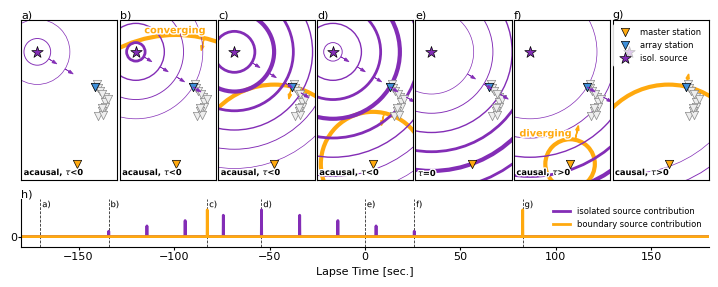

In [8]:
from cmcrameri import cm
from matplotlib.patches import Circle

v = 3

_cm = 1 / 2.54
fig, axs = plt.subplots(1, 7, sharex=True, sharey=True, figsize=(18 * _cm, 8 * _cm))
fig.subplots_adjust(left=0.02, right=0.99, bottom=0.3, top=0.95, wspace=0.025)
dist__ = np.linalg.norm(isolated_source - array_stations[0])
dist_ = np.linalg.norm(isolated_source - master_station)
dist = np.linalg.norm(array_stations[0] - master_station)
main_arrival_time_of_isolated_source = (dist_ - dist__) / v
main_arrival_time_of_master_station = dist / v
excitations = 5
first_arrival = -main_arrival_time_of_isolated_source - (excitations - 1) * interval
# print(main_arrival_time_of_isolated_source, first_arrival)
times_to_plot = (
    -170,
    first_arrival,
    -main_arrival_time_of_master_station,
    -main_arrival_time_of_isolated_source,
    0,
    25.75,
    main_arrival_time_of_master_station,
)
labels = ["a)", "b)", "c)", "d)", "e)", "f)", "g)"]
# interval = 40

for ax, time_to_plot, label in zip(axs, times_to_plot, labels):
    ax.set_aspect("equal")
    # first term
    crcl = Circle(
        master_station, radius=np.abs(time_to_plot) * v, fc="None", ec=cmap(1), lw=3
    )
    ax.add_patch(crcl)

    # second term
    x_of_term = (
        time_to_plot + np.linalg.norm(master_station - isolated_source) / v
    ) * v
    # if x_of_term < 0:
    #     x_of_term = 0
    # sidelobes
    for excitation in range(1, excitations):
        x_of_sidelobe_1 = x_of_term + excitation * interval * v
        x_of_sidelobe_2 = x_of_term - excitation * interval * v

        if x_of_sidelobe_1 >= 0:
            crcl = Circle(
                isolated_source,
                radius=x_of_sidelobe_1,
                fc="None",
                ec=cmap(4),
                # alpha=1 / excitation,
                lw=2 / excitation,
            )
            ax.add_patch(crcl)

        if x_of_sidelobe_2 >= 0:
            crcl = Circle(
                isolated_source,
                radius=x_of_sidelobe_2,
                fc="None",
                ec=cmap(4),
                # alpha=1 / excitation,
                lw=2 / excitation,
            )
            ax.add_patch(crcl)

    if x_of_term >= 0:
        crcl = Circle(isolated_source, radius=x_of_term, fc="None", ec=cmap(4), lw=3)
        ax.add_patch(crcl)

    # ax.set_title(f"{label} "+r"$\tau$="+f"{time_to_plot} sec.", pad=0, loc="left")
    ax.set_title(f"{label}", pad=0, loc="left")
    # if time_to_plot < 0:
    #     ax.set_title(f"{label} " + r"acausal, $\tau$<0", pad=0, loc="left")
    # elif time_to_plot == 0:
    #     ax.set_title(f"{label} " + r"$\tau$=0", pad=0, loc="left")
    # elif time_to_plot > 0:
    #     ax.set_title(f"{label} " + r"causal, $\tau$>0", pad=0, loc="left")
    # time_idx = np.argmin(np.abs(lapsetimes - time_to_plot))
    # ax.scatter(*grid_points.T, c=GFs[:, time_idx], cmap=cm.grayC)
    ax.scatter(
        *master_station, marker="v", fc=cmap(1), ec="k", lw=0.5, label="master station"
    )
    ax.scatter(*array_stations.T, marker="v", fc="#EEE", ec="#888", lw=0.5)
    # ax.scatter(*array_stations[0], marker="v", fc=cmap(1), ec=cmap(2), lw=2)
    ax.scatter(
        *array_stations[0],
        marker="v",
        fc=cmap(0),
        ec="k",
        lw=0.5,
        label="array station",
    )
    ax.scatter(
        *isolated_source,
        marker="*",
        s=75,
        fc=cmap(4),
        ec="k",
        lw=0.5,
        label="isol. source",
    )

    ax.spines.right.set_visible(True)
    ax.spines.top.set_visible(True)

    if time_to_plot < 0:
        txt = r"acausal, $\tau$<0"
    elif time_to_plot == 0:
        txt = r"$\tau$=0"
    elif time_to_plot > 0:
        txt = r"causal, $\tau$>0"
    ax.text(
        0.025,
        0.0125,
        txt,
        va="bottom",
        ha="left",
        transform=ax.transAxes,
        fontsize=6,
        fontweight="bold",
        path_effects=[pe.withStroke(linewidth=2, foreground="w")],
    )


ax.set_xlim(-250, 50)
ax.set_ylim(-250, 250)
ax.set_xticks([])
ax.set_yticks([])

axs[-1].legend(loc=1, fontsize=6)

x0, y0, w, h = axs[0].get_position().bounds
x0_2, y0, w, h = axs[-1].get_position().bounds
x0_3, y0, w, h = axs[1].get_position().bounds
wspace_dist = 0.01
ccf_ax = fig.add_axes([x0, y0 - 0.4 * h - wspace_dist, (x0_2 + w) - x0, 0.3 * h])
ccf_ax.spines.right.set_visible(False)
ccf_ax.spines.top.set_visible(False)
ccf_ax.set_xlabel("Lapse Time [sec.]")

# max_time = 300
# freq = 25
# lapsetimes = np.arange(-max_time, max_time + 1 / freq, 1 / freq)
# ccf_ax.plot(lapsetimes, np.random.uniform(-.5, .5, lapsetimes.shape))
ccf_ax.plot(
    lapsetimes,
    isolated_source_contribution,
    c=cmap(4),
    label="isolated source contribution",
    lw=2,
)
ccf_ax.plot(
    lapsetimes,
    boundary_source_contribution,
    c=cmap(1),
    label="boundary source contribution",
    lw=2,
)
ccf_ax.legend(loc=1)

# ccf_ax.text(-103, 1.4, "h) correlation function at ", ha="right", va="center")
ccf_ax.set_title("h)", pad=0, loc="left")
# ccf_ax.scatter(-85, 1.6, marker="v", fc=cmap(1), ec="w", lw=0.5, clip_on=False)
# ccf_ax.scatter(-76, 1.6, marker="v", fc=cmap(0), ec="w", lw=0.5, clip_on=False)

import matplotlib.patheffects as pe


for time_to_plot, label in zip(times_to_plot, labels):
    ccf_ax.plot(
        [time_to_plot, time_to_plot],
        [-0.4, 1.4],
        c="k",
        clip_on=False,
        dashes=[4, 2],
        lw=0.5,
        zorder=0,
    )
    t = ccf_ax.text(
        time_to_plot + 1,
        1.2,
        label,
        va="center",
        ha="left",
        fontsize=6,
        path_effects=[pe.withStroke(linewidth=0.5, foreground="w")],
    )

ccf_ax.set_xlim(-180, 180)
ccf_ax.set_ylim(-0.4, 1.4)
ccf_ax.set_yticks([0])


asdf = isolated_source - array_stations[0]
angle_isol = np.arcsin(asdf[1] / asdf[0]) + np.pi / 32
times_to_plot_now = (
    np.array(times_to_plot) + np.linalg.norm(master_station - isolated_source) / v
)

asdf = array_stations[0] - master_station
angle_array = (np.pi / 2 - np.arcsin(asdf[0] / asdf[1])) + np.pi

# times_to_plot_now[0] = times_to_plot_now[1] - 2 * v
# times_to_plot_now =
distances_to_plot_isol = v * times_to_plot_now
# print(distances_to_plot)
# print(distances_to_plot)
# distances_to_plot_isol = [43, 30, 65, 32, 135, 210, 300]
# distances_to_plot_isol = [43, 30, 65, 32, 135, 300, 300]
distances_to_plot_isol = [0] * 7
# for excitation in range(1, excitations):
#         x_of_sidelobe_1 = x_of_term + excitation * interval * v
#         x_of_sidelobe_2 = x_of_term - excitation * interval * v
# distances_to_plot_isol[0] = 105
# distances_to_plot_isol[1] = 30
# distances_to_plot_isol[3] = distances_to_plot_isol[2] + 25
# distances_to_plot_isol[-2] = 210
# distances_to_plot_isol[-1] = 380


def line_array_master(x, array_station, master_station):
    m = (array_station - master_station)[1] / (array_station - master_station)[0]
    n = array_station[1] + 100
    y = m * x + n
    return y


x = np.array([-500, 500])
y = line_array_master(
    x=x, array_station=array_stations[0], master_station=master_station
)


dx = 60 * np.cos(angle_array)
dy = 60 * np.sin(angle_array)

position = (
    master_station[0] - 100 * np.cos(angle_array) - 10,
    master_station[1] - 100 * np.sin(angle_array),
)

# axs[2].arrow(
#     *position,
#     dx=dx,
#     dy=dy,
#     ec=cmap(1),
#     fc=cmap(1),
#     shape="left",
#     length_includes_head=True,
#     head_width=20,
#     lw=1,
#     zorder=0,
# )

# axs[2].text(
#     master_station[0] - 75 * np.cos(angle_array) - 20,
#     master_station[1] - 75 * np.sin(angle_array) + 10,
#     "converging",
#     ha="right",
#     va="center",
#     c=cmap(1),
#     # rotation=np.degrees(angle_array) + 180,
#     fontsize=6,
#     fontweight="bold",
#     path_effects=[pe.withStroke(linewidth=1, foreground="w")]
# )

# axs[2].plot([master_station[0], array_stations[0][0]], [master_station[1], array_stations[0][1]], c=cmap(1), dashes=[4, 2], lw=0.5, zorder=0)

# position = (
#     master_station[0] - 100 * np.cos(angle_array) + 10 + dx,
#     master_station[1] - 100 * np.sin(angle_array) + dy,
# )

# axs[-1].arrow(
#     *position,
#     dx=-dx,
#     dy=-dy,
#     ec="w",
#     fc="w",
#     shape="left",
#     length_includes_head=True,
#     head_width=20,
#     lw=1,
#     zorder=0,
# )

# axs[-1].text(
#     master_station[0] - 125 * np.cos(angle_array) + 40 + dx,
#     master_station[1] - 125 * np.sin(angle_array) + dy,
#     "diverging",
#     ha="center",
#     va="center",
#     c="w",
#     rotation=np.degrees(angle_array) + 180,
#     fontsize=7,
#     fontweight="bold",
#     path_effects=[pe.withStroke(linewidth=1, foreground="w")]
# )

# axs[-1].plot([master_station[0], array_stations[0][0]], [master_station[1], array_stations[0][1]], c=cmap(1), dashes=[4, 2], lw=0.5, zorder=0)

times_to_plot_now = (
    np.array(times_to_plot) + np.linalg.norm(master_station - array_stations[0]) / v
)
distances_to_plot_bound = v * times_to_plot_now
distances_to_plot_bound[0] = 500
distances_to_plot_bound[-1] = distances_to_plot_bound[2]
distances_to_plot_bound[-2] = 165

for ax, time_to_plot, distance_to_plot_isol, distance_to_plot_bnd in zip(
    axs, times_to_plot, distances_to_plot_isol, distances_to_plot_bound
):
    x_of_term = (
        time_to_plot + np.linalg.norm(master_station - isolated_source) / v
    ) * v
    for excitation in range(1, excitations):
        x_of_sidelobe_1 = x_of_term + excitation * interval * v
        x_of_sidelobe_2 = x_of_term - excitation * interval * v
        if x_of_sidelobe_1 >= 5:
            # isol. contrib.
            position = (
                isolated_source[0] + x_of_sidelobe_1 * np.cos(angle_isol),
                isolated_source[1] + x_of_sidelobe_1 * np.sin(angle_isol),
            )
            dx = 30 * np.cos(angle_isol)
            dy = 30 * np.sin(angle_isol)

            lw = 0.5
            ec = cmap(4)

            ax.arrow(
                *position,
                dx=dx,
                dy=dy,
                ec=cmap(4),
                fc=cmap(4),
                shape="full",
                length_includes_head=True,
                head_width=10,
                lw=lw,
            )
        if x_of_sidelobe_2 >= 5:
            # isol. contrib.
            position = (
                isolated_source[0] + x_of_sidelobe_2 * np.cos(angle_isol),
                isolated_source[1] + x_of_sidelobe_2 * np.sin(angle_isol),
            )
            dx = 30 * np.cos(angle_isol)
            dy = 30 * np.sin(angle_isol)

            lw = 0.5
            ec = cmap(4)

            ax.arrow(
                *position,
                dx=dx,
                dy=dy,
                ec=cmap(4),
                fc=cmap(4),
                shape="full",
                length_includes_head=True,
                head_width=10,
                lw=lw,
            )
    if x_of_term >= 0:
        position = (
            isolated_source[0] + x_of_term * np.cos(angle_isol),
            isolated_source[1] + x_of_term * np.sin(angle_isol),
        )
        dx = 30 * np.cos(angle_isol)
        dy = 30 * np.sin(angle_isol)

        lw = 0.5
        ec = cmap(4)

        ax.arrow(
            *position,
            dx=dx,
            dy=dy,
            ec=cmap(4),
            fc=cmap(4),
            shape="full",
            length_includes_head=True,
            head_width=10,
            lw=lw,
        )

    if ax in [axs[1]]:
        ax.text(
            array_stations[0][0] + (distance_to_plot_bnd - 25) * np.cos(angle_array),
            array_stations[0][1] + (distance_to_plot_bnd - 25) * np.sin(angle_array),
            "converging",
            ha="right",
            va="center",
            c=cmap(1),
            # rotation=np.degrees(angle_array) + 180,
            fontsize=7,
            fontweight="bold",
            path_effects=[pe.withStroke(linewidth=2, foreground="w")],
        )
    elif ax in [axs[-2]]:
        ax.text(
            array_stations[0][0]
            + (distance_to_plot_bnd - 20) * np.cos(angle_array)
            - 15,
            array_stations[0][1]
            + (distance_to_plot_bnd - 20) * np.sin(angle_array)
            - 5,
            "diverging",
            ha="right",
            va="center",
            c=cmap(1),
            # rotation=np.degrees(angle_array) + 180,
            fontsize=7,
            fontweight="bold",
            path_effects=[pe.withStroke(linewidth=2, foreground="w")],
        )

    # ax.plot(
    #     [isolated_source[0], array_stations[0][0]],
    #     [isolated_source[1], array_stations[0][1]],
    #     c=cmap(4),
    #     dashes=[4, 2],
    #     lw=0.5,
    #     zorder=0,
    #     )

    # boundary contrib.
    position = (
        array_stations[0][0] + distance_to_plot_bnd * np.cos(angle_array),
        array_stations[0][1] + distance_to_plot_bnd * np.sin(angle_array),
    )

    # ax.plot(x, y, c=cmap(1), dashes=[4, 2], lw=0.5, zorder=0)

    if ax == axs[-3]:
        continue

    if ax == axs[-2]:
        angle_array -= np.pi

    dx = 40 * np.cos(angle_array)
    dy = 40 * np.sin(angle_array)
    ax.arrow(
        *position,
        dx=dx,
        dy=dy,
        ec=cmap(1),
        fc=cmap(1),
        shape="full",
        length_includes_head=True,
        head_width=10,
        lw=1,
        zorder=0,
    )

    # if ax in [axs[2], axs[3]]:
    #     ax.arrow(
    #         isolated_source[0] + distance_to_plot * np.cos(angle) - 50 * np.cos(angle),
    #         isolated_source[1] + distance_to_plot * np.sin(angle) - 50 * np.sin(angle),
    #         dx=50 * np.cos(angle),
    #         dy=50 * np.sin(angle),
    #         ec=cmap(1),
    #         fc=cmap(1),
    #         shape="full",
    #         length_includes_head=True,
    #         head_width=15,
    #         lw=2
    #     )
    # elif ax == axs[5]:
    #     ax.arrow(
    #         master_station[0] - 30 * v * np.cos(angle),
    #         master_station[1] - 30 * v * np.sin(angle),
    #         dx=-50 * np.cos(angle),
    #         dy=-50 * np.sin(angle),
    #         ec=cmap(1),
    #         fc=cmap(1),
    #         shape="full",
    #         length_includes_head=True,
    #         head_width=15,
    #         lw=2
    #     )
    # elif ax == axs[6]:
    #     ax.arrow(
    #         master_station[0] - times_to_plot[5] * v * np.cos(angle),
    #         master_station[1] - times_to_plot[5] * v * np.sin(angle),
    #         dx=-50 * np.cos(angle),
    #         dy=-50 * np.sin(angle),
    #         ec=cmap(1),
    #         fc=cmap(1),
    #         shape="full",
    #         length_includes_head=True,
    #         head_width=15,
    #         lw=2
    #     )
    # pass

plt.rcParams.update(
    {
        "figure.facecolor": (1.0, 0.0, 0.0, 0.3),  # red   with alpha = 30%
        "axes.facecolor": (0.0, 1.0, 0.0, 0.5),  # green with alpha = 50%
        "savefig.facecolor": (0.0, 0.0, 1.0, 0.0),  # blue  with alpha = 20%
    }
)

fig.savefig("../figures/Fig4_sketch.pdf", dpi=300)
